# Potato Plant Images EDA

We will take a closer look at the the potato plant images. There are three classes of potato plant images: Healthy, Early Blight and Late Blight.

EDA Heavily inspired by this [article](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

import os

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#set an the folder name of plant images, this will be used to find file path ways and name saved files
folder = "Potato"

In [4]:
#un zips image data from https://drive.google.com/drive/folders/17ubtdWViDJiBIFcHZz2vQOArMD7_8Zxk?usp=share_link
#got idea from https://stackoverflow.com/questions/56668739/how-to-unzip-a-folder-passing-a-variable
unzip_path = f'/content/drive/MyDrive/datasets/{folder}'
!unzip -q "$unzip_path"

We will first load all the images from our Potato folder. There should be three classes. For potatoes there should be 2152 Images

In [5]:
plant = image_dataset_from_directory(
    folder,
    image_size=(256, 256),
    batch_size=32,
)

Found 2152 files belonging to 3 classes.


In [6]:
#Idea from lab 2.02 https://git.generalassemb.ly/derik/lab-2.02-excel/blob/master/starter-code.ipynb
path = f'/content/{folder}'
plant_dir = [x for x in os.listdir(path)]

In [7]:
folders= os.listdir(path)
folders

['Potato_Early_blight', 'Potato_healthy', 'Potato_Late_blight']

Next, we have a few sample images from each class, and get a count of how many images are in each class

Potato_Early_blight has 1000 files


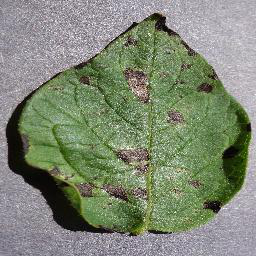

Potato_healthy has 152 files


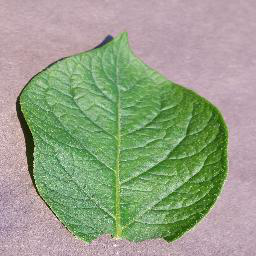

Potato_Late_blight has 1000 files


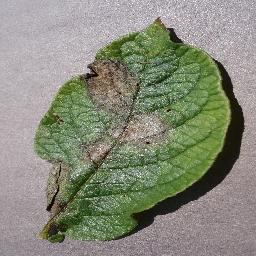

In [8]:
#loop to each sub folder so we can get the class sizes
for i in folders:
  #prints the number of images in each sub folder
  print(f"{i} has {len(os.listdir(f'{path}/{i}'))} files")
  #gets the name of the image
  image_name = os.listdir(f'{path}/{i}')[0]
  #loads the image using the pathway
  image = load_img(f'{path}/{i}/{image_name}')
  #shows the image for each class
  image.show()

According to this report the number of files in each class is as follows:

1) Potato Healthy: 152

2) Potato Early Blight: 1000

3) Potato Late Blight 1000

As we can see here there is a significant class inbalanced between healthy potatos and potatos with blight. In this case if were modeling healthy vs unhealthy we would need to either oversample healthy potatoes or under sample potatoes with blight. Additionally, we can add an audmentaion layer to our healthy class to get more representation.

------
## We want to create a single image that represents the average of all the images in each class. 

CHAT-GPT 4 code that we turned into a function

Prompt: "I have an image data set that I want to do EDA on. How can I average out the pixel values of all the images in a class. python keras"

In [9]:
def avg_images(sub_folder):
  '''
  This function is used to find the average pixel values of each class
  The purpose is to find if there is a difference in each class
  '''
  #assign the path in the function for readability and understanding
  path = f'/content/{folder}/'
  #assign the sub folder (class name) that was passed to the function
  class_name = sub_folder
  batch_size = 32  # Modify this to suit your needs
  #instantiate ImageDataGenerator
  datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values to [0,1]
  #get the images from the directory
  generator = datagen.flow_from_directory(path,
                                          classes=[class_name],
                                          class_mode=None,
                                          color_mode='rgb',
                                          target_size=(256, 256),
                                          batch_size=batch_size)
  n_samples = generator.samples
  average_image = np.zeros((256, 256, 3))

  for i in range(n_samples // batch_size):  # Integer division to avoid partial batches
      images = next(generator)
      average_image += np.sum(images, axis=0)

  average_image /= n_samples
  return average_image

Found 152 images belonging to 1 classes.


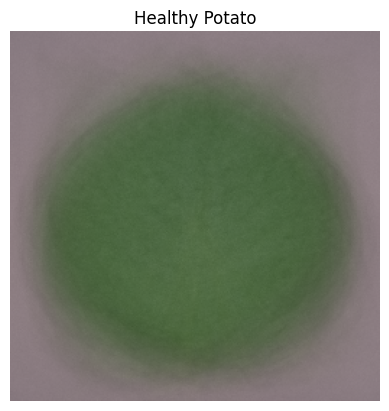

In [10]:
healthy_average_image = avg_images(f'{folder}_healthy')
plt.title(f'Healthy {folder}')
plt.axis('off')
plt.imshow(healthy_average_image)
plt.savefig(f'Healthy_{folder}.png')

Found 1000 images belonging to 1 classes.


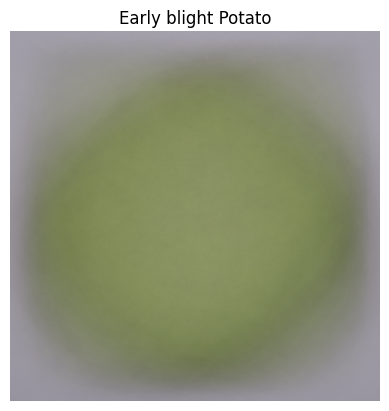

In [11]:
early_blight_average_image = avg_images(f'{folder}_Early_blight')
plt.title(f'Early blight {folder}')
plt.axis('off')
plt.imshow(early_blight_average_image)
plt.savefig(f'Early_blight_{folder}.png')

Found 1000 images belonging to 1 classes.


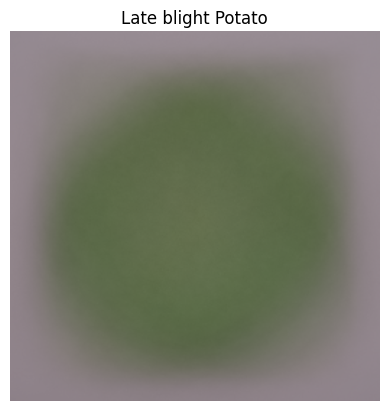

In [12]:
late_blight_average_image = avg_images(f'{folder}_Late_blight')
plt.title(f'Late blight {folder}')
plt.axis('off')
plt.imshow(late_blight_average_image)
plt.savefig(f'Late_blight_{folder}.png')

Although not immediately obvious there is already a difference that can be obveserved in the averaging of the pixel values of the three different classes. The healthy leaves show a bit more of a lighter green and shine. This could be indicative that healthier leaves reflect light better. The early blight leaves averaged out the darkest. This could be indicative that the loss of health lead to less reflectiveness in the leaves. The dark patches were also lowering the average value as well. The Late Blight, however, averaged out even lighter, but the it still doesn't have as much a reflectiveness to it, and the color value started to shift to yellow, presumably from all the green and brown color values from mixing.

### Looking at the contrasts between the class image averages:

In [13]:
contrast_healthy_early = healthy_average_image - early_blight_average_image
contrast_healthy_late = healthy_average_image - late_blight_average_image
contrast_early_late = early_blight_average_image - late_blight_average_image

In [14]:
# we need to rescale the contrasts
contrasts = [contrast_healthy_early, contrast_healthy_late, contrast_early_late]

for contrast in contrasts:
  # rescale to [0, 1]
  contrast -= contrast.min() # subtract minimum 
  contrast /= contrast.max() # divide by new max

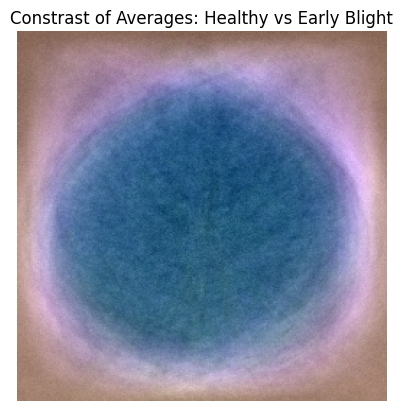

In [15]:
plt.title(f"Constrast of Averages: Healthy vs Early Blight")
plt.imshow(contrast_healthy_early, cmap='PRGn')
plt.axis('off')
plt.savefig(f'{folder}_contrast_healthy_early.png')

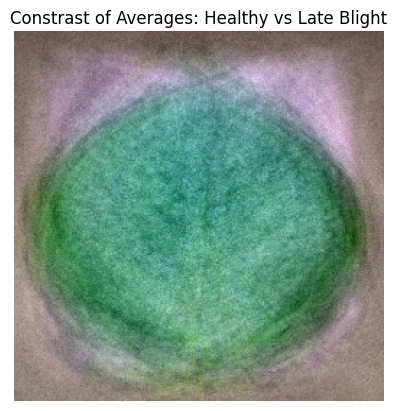

In [16]:
plt.title(f"Constrast of Averages: Healthy vs Late Blight")
plt.imshow(contrast_healthy_late, cmap='PRGn')
plt.axis('off')
plt.savefig(f'{folder}_contrast_healthy_late.png')

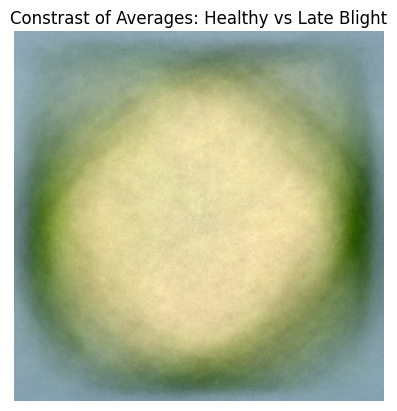

In [17]:
plt.title(f"Constrast of Averages: Healthy vs Late Blight")
plt.imshow(contrast_early_late, cmap='PRGn')
plt.axis('off')
plt.savefig(f'{folder}_contrast_early_late.png')

These contrasts between image averages show high contrasts between them all.

_________________________________________________
### Looking at the standard deviation of the image averages for each class:

In [18]:
def sd_images(sub_folder, average_image):
  path = f'/content/{folder}/'
  class_name = sub_folder
  batch_size = 32  # Modify this to suit your needs

  datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values to [0,1]
  generator = datagen.flow_from_directory(path,
                                          classes=[class_name],
                                          class_mode=None,
                                          color_mode='rgb',
                                          target_size=(256, 256),
                                          batch_size=batch_size)

  n_samples = generator.samples
  standard_deviation_image = np.zeros((256, 256, 3))

  for i in range(n_samples // batch_size):  # Integer division to avoid partial batches
      images = next(generator)
      standard_deviation_image += np.sum((images - average_image) ** 2, axis=0)

  standard_deviation_image /= n_samples - 1
  return np.sqrt(standard_deviation_image)

Found 152 images belonging to 1 classes.


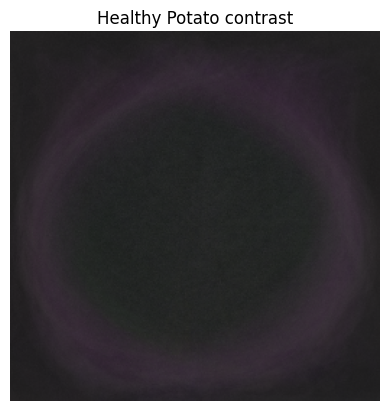

In [19]:
healthy_sd_image = sd_images(f'{folder}_healthy', healthy_average_image)
plt.title(f'Healthy {folder} contrast')
plt.axis('off')
plt.imshow(healthy_sd_image)
plt.savefig(f'Healthy_{folder}_contrast.png')

Found 1000 images belonging to 1 classes.


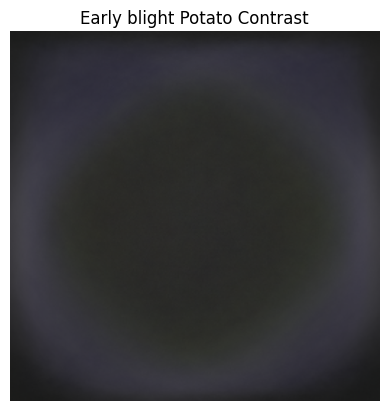

In [20]:
early_blight_sd_image = sd_images(f'{folder}_Early_blight', early_blight_average_image)
plt.title(f'Early blight {folder} Contrast')
plt.axis('off')
plt.imshow(early_blight_sd_image)
plt.savefig(f'Early_blight_{folder}_contrast.png')

Found 1000 images belonging to 1 classes.


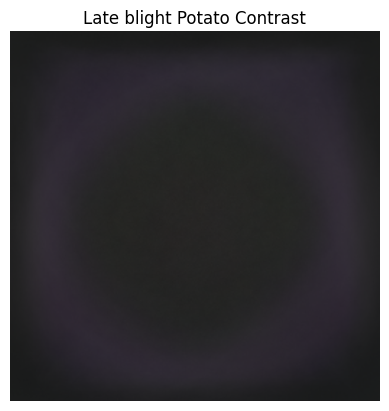

In [21]:
late_blight_sd_image = sd_images(f'{folder}_Late_blight', late_blight_average_image)
plt.title(f'Late blight {folder} Contrast')
plt.axis('off')
plt.imshow(late_blight_sd_image)
plt.savefig(f'Late_blight_{folder}_Contrast.png')

----
## Looking at the eigenimages for each class:

The idea of eigenimaging was based off this [article](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2://).

In [22]:
# Names of the classes
class_names = ['Potato_healthy', 'Potato_Early_blight', 'Potato_Late_blight']

In [23]:
def load_and_preprocess_data(class_name):

    '''
    The purpose of this function is to load and process the data in the Potato 
    folder.

    The function takes in a string for the potato class you want to load

    The funtion returns the loaded images from the generator.
    '''

    path = f'/content/{folder}/'
    datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values to [0,1]
    generator = datagen.flow_from_directory(folder,
                                            classes=[class_name],
                                            class_mode=None,
                                            color_mode='rgb',
                                            target_size=(256, 256),
                                            batch_size=32)
    return generator

In [24]:
def eigenimages(full_mat, n_comp=50):
    '''
    The purpose of this function is to perform PCA on flattened images

    The function takes in a list of images 
    and the number of components; the default is 50

    The funtion returns a PCA model.
    '''
    
    pca = PCA(n_components=n_comp, whiten=True)
    pca.fit(np.array(full_mat))
    print('Number of PC: ', pca.n_components_)
    return pca


In [25]:
def plot_pca(pca, class_name, size=(256, 256, 3)):
    '''
    The purpose of this function is to plot the PCA

    The function takes in the pca model, the class name, and size of the images

    The funtion doesnt return anything, but plots the PCA.
    '''

    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks=[], yticks=[])
        img = pca.components_[i].reshape(size)
        img -= img.min()  # ensure the minimal value is 0.0
        img /= img.max()  # ensure the maximal value is 1.0
        ax.imshow(img)
    plt.suptitle(f'Eigenimages for {class_name.replace("_", " ").title()}')
    plt.axis('off')
    plt.savefig(f'{folder}_eigenimages_for_{class_name}.png')
    plt.show()


#### Now we can load data, run PCA, and plot eigenimages for each class

Found 152 images belonging to 1 classes.
Number of PC:  50


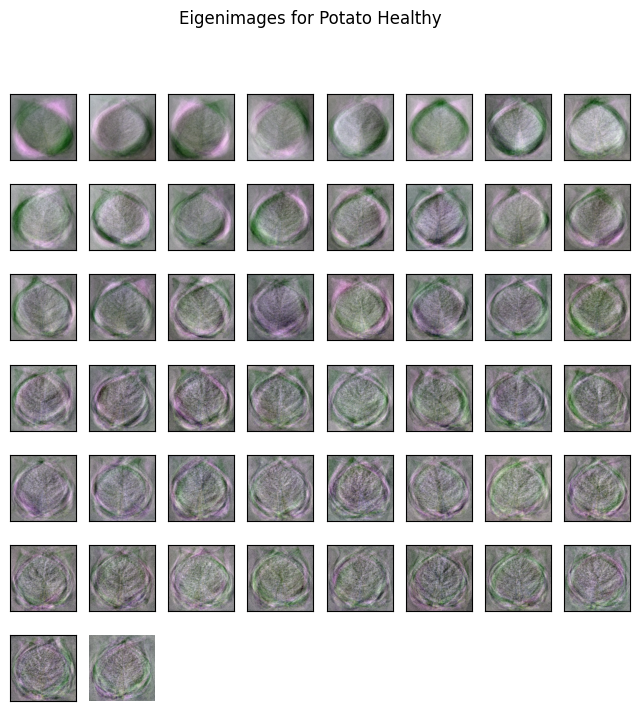

Found 1000 images belonging to 1 classes.
Number of PC:  50


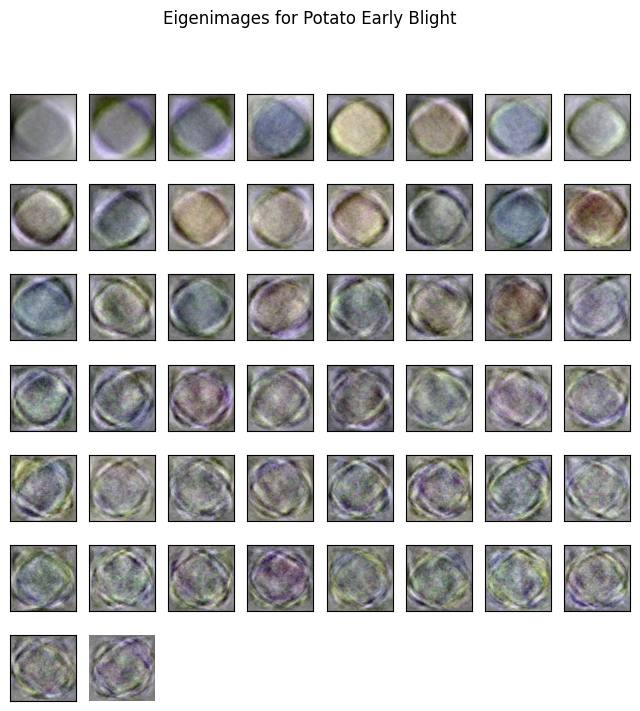

Found 1000 images belonging to 1 classes.
Number of PC:  50


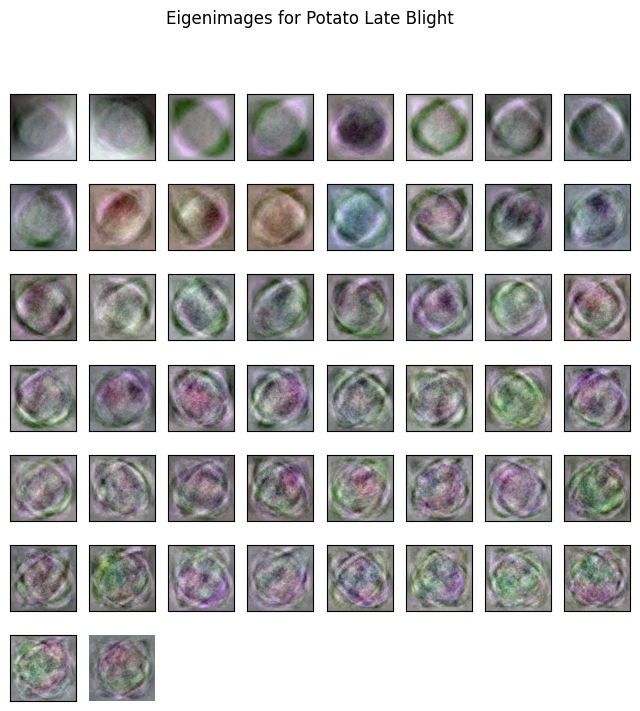

In [26]:
# Load data, run PCA, and plot eigenimages for each class
for class_name in class_names:
    # Load and preprocess data
    ds = load_and_preprocess_data(class_name)
    
    # Flatten and collect a subset of images for PCA
    image_list = []
    
    # Iterate over the generator
    for i in range(10):  # Adjust this value to take more or fewer batches
        images = next(ds)
        for img in images:
            image_list.append(img.flatten())
    
    # Perform PCA
    pca_model = eigenimages(np.array(image_list))
    
    # Plot eigenimages
    plot_pca(pca_model, class_name)

Interpretation of results: We can see that the healthy class shows a lot more leaf structure definition in general (especially along the edges) throughout the eigenimages. The early and late blight classes have a lot more trouble showing the general leaf structure. This makes sense because the blight is warping the overall look of the leaves.